In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

## **Preparing Data**

In [4]:
image_size= 256
batch_size= 32
channels= 3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/PlantVillage',
    batch_size= batch_size,
    shuffle= True,
    image_size= (image_size, image_size)
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names= dataset.class_names

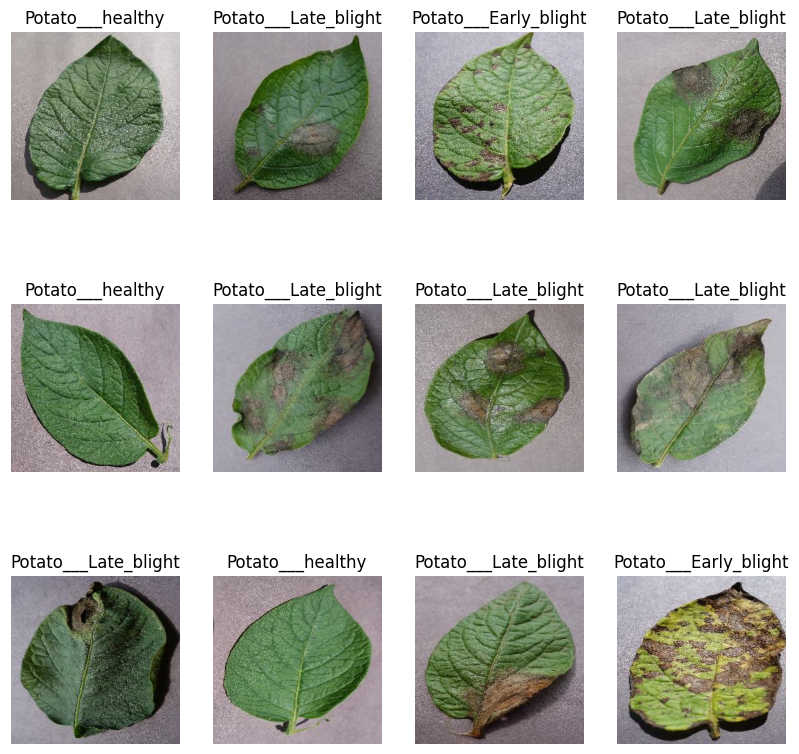

In [5]:
fig, ax= plt.subplots(3,4, figsize= (10,10))
ax= ax.flatten()
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        
       ax[i].imshow(image_batch[i].numpy().astype('uint8'))
       ax[i].axis('off')
       ax[i].set_title(class_names[label_batch[i]])
   

In [6]:
def get_datset_pratitions_tf(ds, train_split= 0.8, val_split= 0.1, shuffle= True):

    ds_size= len(ds)
    

    if shuffle:
        #ds= ds.shuffle(68, seed= 12) #Batched Shuffle
        
        #unbatched Shuffle
        ds_totla_samples= sum(1 for _ in ds.unbatch())
        ds = ds.unbatch().shuffle(ds_totla_samples, seed=12).batch(32)

    train_size= int(train_split * ds_size)
    val_size= int(ds_size * val_split)

    

    train_ds= ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds= get_datset_pratitions_tf(dataset)

In [8]:
train_ds= train_ds.cache().shuffle(54).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(6).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds= test_ds.cache().prefetch(buffer_size= tf.data.AUTOTUNE)

## **Build Model** and **Training**

In [ ]:
resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0/255),
])

In [5]:
augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [11]:
input_shape= (batch_size, image_size, image_size, channels)
n_classes= len(class_names)

In [ ]:
model= models.Sequential([
    resize_and_rescale,
    augmentation_layer,

    layers.Conv2D(32, (3,3), activation= 'relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation= 'relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation= 'relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes),

])

model.build(input_shape= input_shape)

In [106]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_90 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                

In [107]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    metrics= ['accuracy']
)

In [108]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Keep the best model
)

In [109]:
epochs=50

history= model.fit(
    train_ds,
    batch_size= batch_size,
    epochs= epochs,
    verbose=1,
    validation_data= val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50


54/54 [==============================] - 9s 124ms/step - loss: 0.8824 - accuracy: 0.5312 - val_loss: 1.0252 - val_accuracy: 0.5208
Epoch 2/50
54/54 [==============================] - 6s 120ms/step - loss: 0.6740 - accuracy: 0.7170 - val_loss: 0.6511 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 6s 118ms/step - loss: 0.4544 - accuracy: 0.8183 - val_loss: 0.3573 - val_accuracy: 0.8229
Epoch 4/50
54/54 [==============================] - 6s 119ms/step - loss: 0.2540 - accuracy: 0.9062 - val_loss: 0.1667 - val_accuracy: 0.9271
Epoch 5/50
54/54 [==============================] - 6s 117ms/step - loss: 0.1722 - accuracy: 0.9358 - val_loss: 0.2212 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 6s 117ms/step - loss: 0.1496 - accuracy: 0.9456 - val_loss: 0.1425 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 6s 117ms/step - loss: 0.1186 - accuracy: 0.9583 - val_loss: 0.1090 - val_accuracy: 0.9531
Epoch 8/50
54/54 

In [110]:
model.evaluate(test_ds)

8/8 [==============================] - 0s 18ms/step - loss: 0.1056 - accuracy: 0.9698


[0.10564547777175903, 0.9698275923728943]

## **Analysis and Testing**

In [111]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [112]:
accuracy= history.history['accuracy']
val_accuracy= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

In [113]:
epochs=12

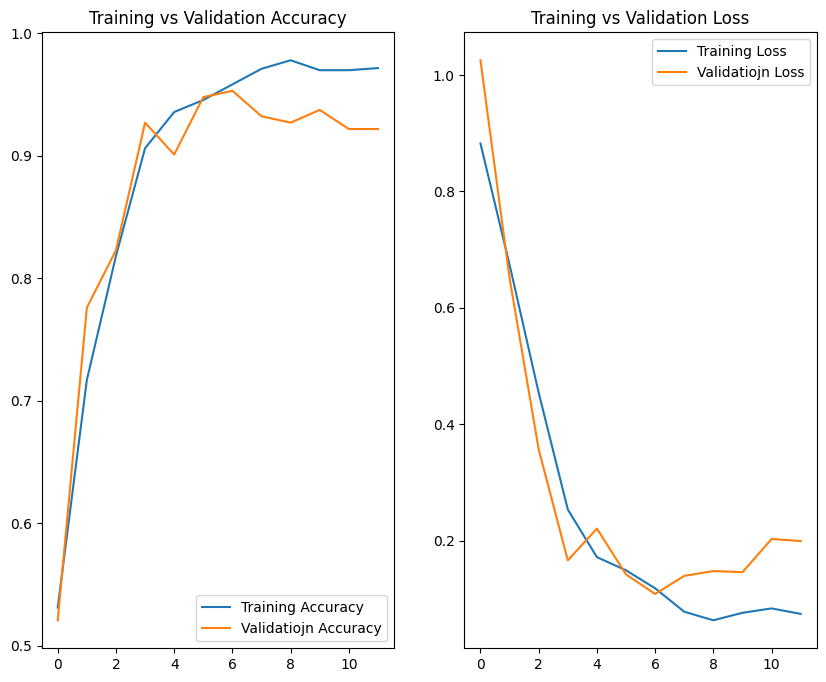

In [114]:
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), accuracy, label= 'Training Accuracy')
plt.plot(range(epochs), val_accuracy, label= 'Validatiojn Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label= 'Training Loss')
plt.plot(range(epochs), val_loss, label= 'Validatiojn Loss')
plt.legend(loc= 'upper right')
plt.title('Training vs Validation Loss')

plt.show()



In [115]:
y_pred= model.predict(test_ds)
y_pred= np.argmax(y_pred, axis= 1)

y_test= []
for _, labels in test_ds:
    y_test.extend(labels.numpy())

y_test= np.array(y_test)


8/8 [==============================] - 0s 38ms/step


In [116]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       114
           1       0.96      0.97      0.97       103
           2       1.00      1.00      1.00        15

    accuracy                           0.97       232
   macro avg       0.98      0.98      0.98       232
weighted avg       0.97      0.97      0.97       232



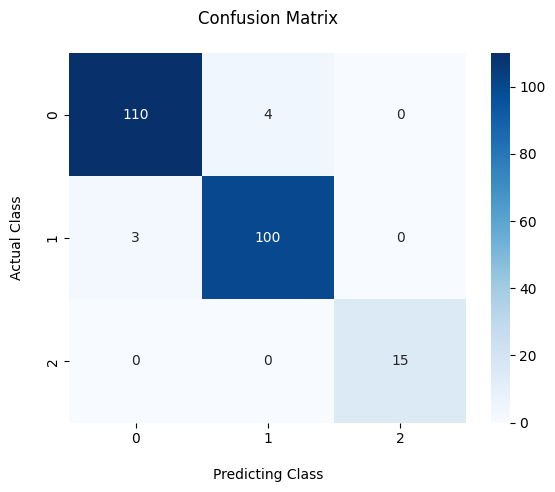

In [117]:
cm= confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot= True, fmt='d', cmap='Blues')
plt.ylabel('Actual Class\n')
plt.xlabel('\nPredicting Class')
plt.title('Confusion Matrix\n')
plt.show()

## Prediction **Test**

Actual Label: Potato___Late_blight
1/1 [==============================] - 0s 95ms/step
Predicting Label: Potato___Late_blight


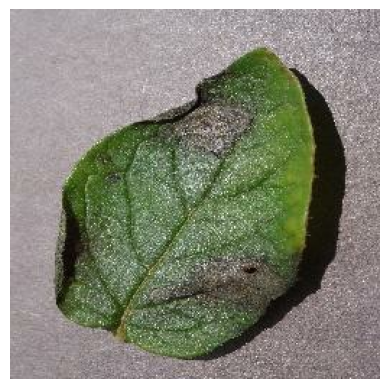

In [118]:
for image_batch, label_batch in test_ds.take(1):

    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    print('Actual Label:', class_names[label_batch[0].numpy()])

    batch_label_pred= model.predict(image_batch)
    print('Predicting Label:', class_names[np.argmax(batch_label_pred[0])])

In [119]:
def single_image_predict(model, img):

    img_array= tf.keras.preprocessing.image.img_to_array(img)
    img_array= tf.expand_dims(img_array, 0)

    pred= model.predict(img_array)

    pred_class= class_names[np.argmax(pred[0])]
    confidence= round(100 * (np.max(tf.nn.softmax(pred[0]))), 2)

    return pred_class, confidence

1/1 [==============================] - 0s 17ms/step


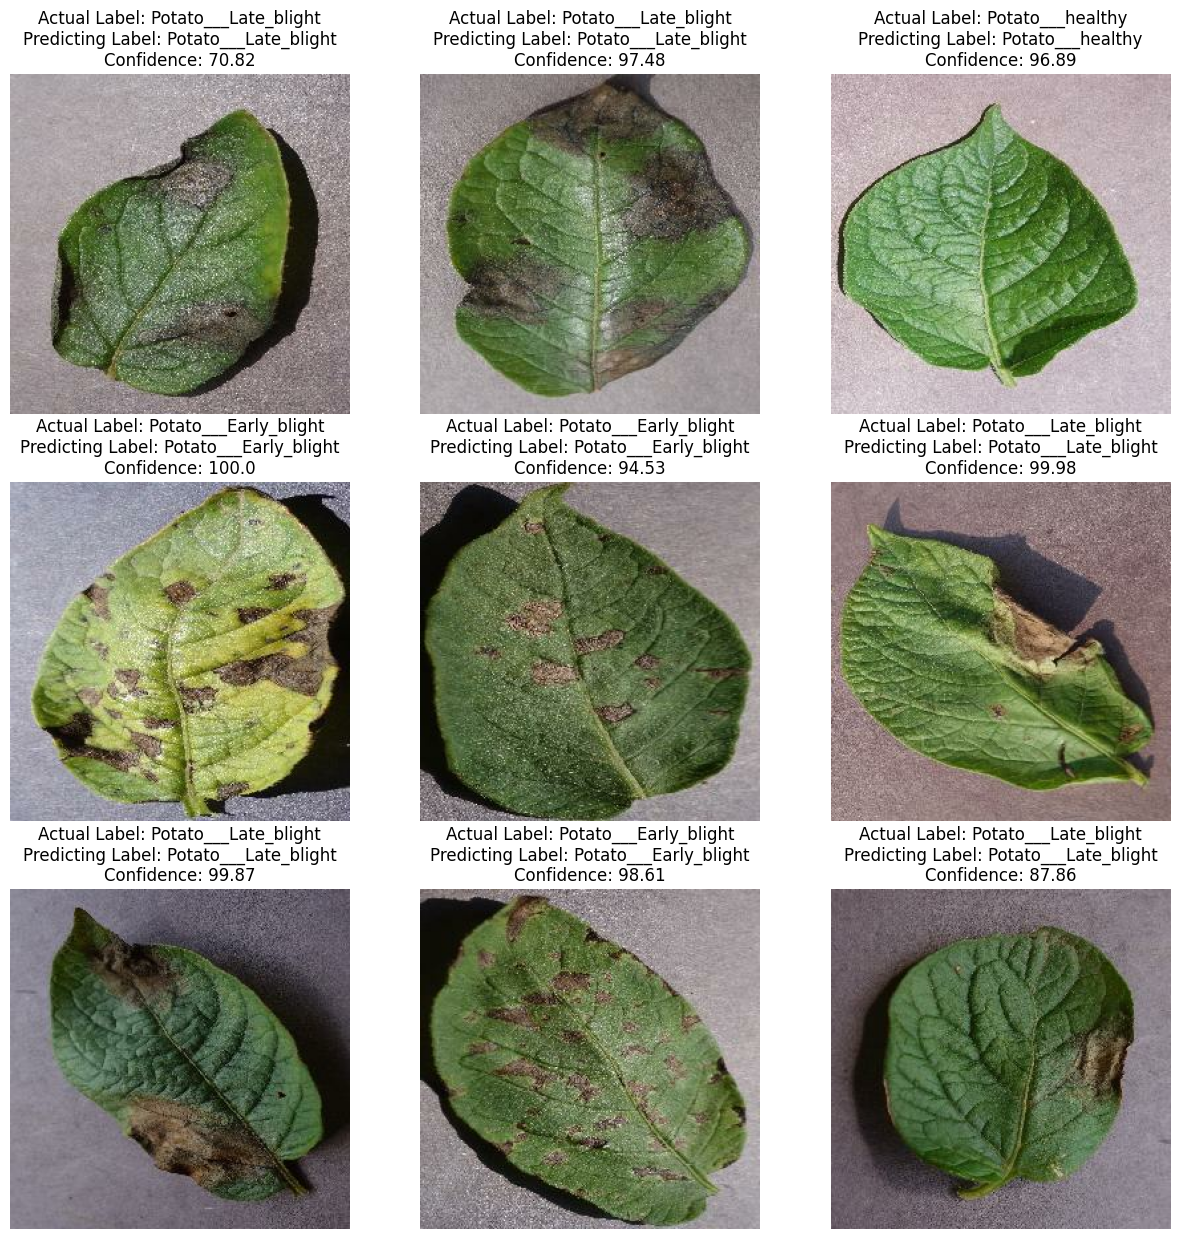

In [120]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in test_ds.take(1):
    for i in range(9):

        class_, conf = single_image_predict(model, image_batch[i].numpy())
        actual_label= class_names[label_batch[i].numpy()]
        
        ax= plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(f'Actual Label: {actual_label}\nPredicting Label: {class_}\nConfidence: {conf}')
        

## Saving **Model**

In [ ]:
model.save('../models/optimized_version')

INFO:tensorflow:Assets written to: ../Models/optimized_version\assets


INFO:tensorflow:Assets written to: ../Models/optimized_version\assets
